In [1]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d 'kmader/skin-cancer-mnist-ham10000'



Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [2]:
import zipfile

dataset_path = 'skin-cancer-mnist-ham10000.zip'
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [2]:
#--------------MULTICLASS PREDICTION AND STUDY FOR SKIN CANCER ----------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
import shutil

import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder




In [3]:
#Datast pre-processing
skin_df = pd.read_csv('/content/dataset/HAM10000_metadata.csv')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


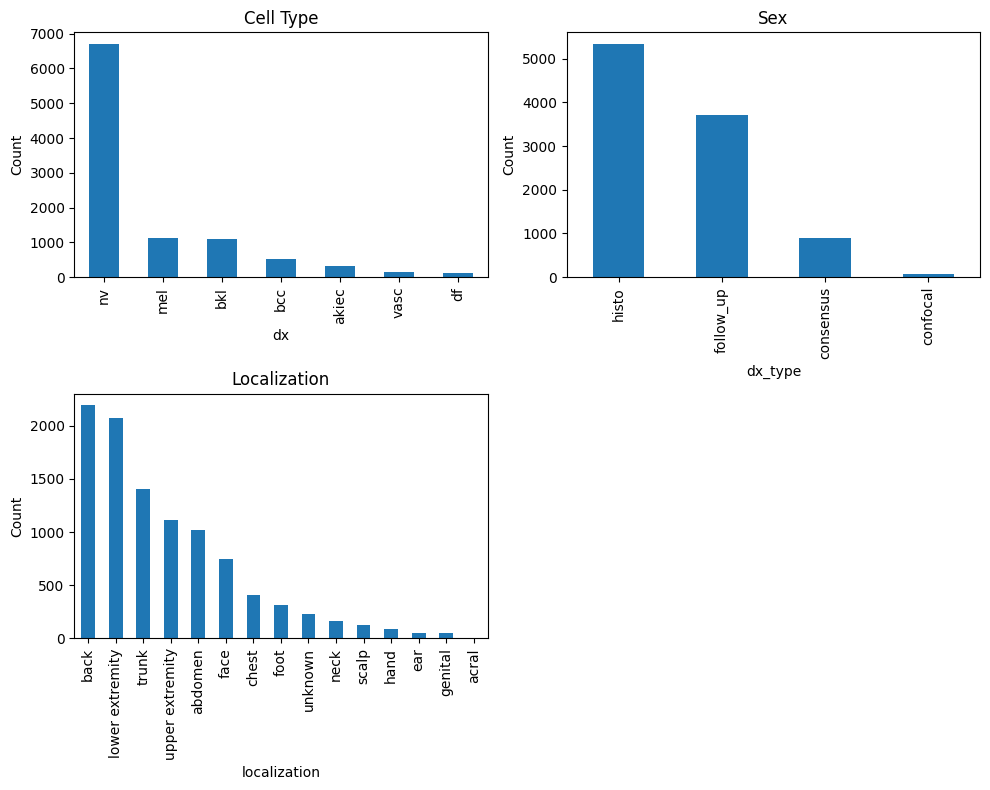

In [4]:
from math import dist

le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])

SIZE = 72

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(2, 2, 1)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

ax2 = fig.add_subplot(2, 2, 2)
skin_df['dx_type'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count')
ax2.set_title('Sex')

ax3 = fig.add_subplot(2, 2, 3)
skin_df['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Count')
ax3.set_title('Localization')


plt.tight_layout()
plt.show()

In [5]:
#Dataset balancing

from sklearn.utils import resample

print(skin_df['label'].value_counts())
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/content/dataset/', '*', '*.jpg'))}

skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

X = np.asarray(skin_df['image'].tolist())
X = X/255.
y = np.asarray(skin_df['label'].tolist())
Y_cat = to_categorical(y, num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=2)



label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [6]:
#--------------------------MULTICLASS PREDICTION MODEL----------------------------
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import Xception

# ViT + Xception model
def create_vit_xception(input_shape=(72, 72, 3), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    patches = layers.Conv2D(64, kernel_size=6, strides=6, padding='valid')(inputs)
    reshaped = layers.Reshape((-1, 64))(patches)

    positions = tf.range(start=0, limit=reshaped.shape[1])
    pos_embed = layers.Embedding(input_dim=reshaped.shape[1], output_dim=64)(positions)
    encoded_patches = reshaped + pos_embed

    # Transformer encoder
    for _ in range(4):
        x1 = layers.LayerNormalization()(encoded_patches)
        attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x1, x1)
        x2 = layers.Add()([attn_output, encoded_patches])

        x3 = layers.LayerNormalization()(x2)
        # I previously used Gelu as activation ut I met some errors in model loading phase, so I changed it to ReLu
        x3 = layers.Dense(64, activation='relu')(x3)
        encoded_patches = layers.Add()([x3, x2])

    vit_out = layers.Flatten()(encoded_patches)

    # Xception
    xception = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    xception.trainable = False
    x = xception(inputs, training=False)
    xception_out = layers.GlobalAveragePooling2D()(x)

    # Model fusion
    combined = layers.Concatenate()([vit_out, xception_out])
    combined = layers.Dense(1024, activation='relu')(combined)
    combined = layers.Dropout(0.3)(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model creation + compiling
model = create_vit_xception()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import ModelCheckpoint

# Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath="./best_model_multiclass_weightChange.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

# Always balancing using class weight balances
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_int = np.argmax(y_train, axis=1)

# Class weights computation
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)

class_weights = dict(enumerate(class_weights))

print(class_weights)





83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
{0: np.float64(4.419194704908991), 1: np.float64(2.7848453249913105), 2: np.float64(1.2788507581803672), 3: np.float64(12.577708006279435), 4: np.float64(1.303612105434429), 5: np.float64(0.2131417930300612), 6: np.float64(10.597883597883598)}


In [7]:
#Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 72, 72, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 12, 12, 64)     │          6,976 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 144, 64)        │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 144, 64)        │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 144, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 144, 64)        │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 144, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 144, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 144, 64)        │          4,160 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 144, 64)        │              0 │ dense[0][0],           │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 144, 64)        │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 144, 64)        │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 144, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 144, 64)        │            128 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 144, 64)        │          4,160 │ layer_normalization_3… │
├──────────────────────

 Total params: 32,694,127 (124.72 MB)

 Trainable params: 11,832,647 (45.14 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2454 - loss: 3.5898
Epoch 1: val_accuracy improved from -inf to 0.38742, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - accuracy: 0.2460 - loss: 3.5806 - val_accuracy: 0.3874 - val_loss: 1.5778 - learning_rate: 1.0000e-04
Epoch 2/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4749 - loss: 1.5967
Epoch 2: val_accuracy improved from 0.38742 to 0.53819, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - accuracy: 0.4748 - loss: 1.5968 - val_accuracy: 0.5382 - val_loss: 1.3230 - learning_rate: 1.0000e-04
Epoch 3/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4384 - loss: 1.5485
Epoch 3: val_accuracy improved from 0.53819 to 0.59411, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.4390 - loss: 1.5480 - val_accuracy: 0.5941 - val_loss: 1.0534 - learning_rate: 1.0000e-04
Epoch 4/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5180 - loss: 1.3985
Epoch 4: val_accuracy did not improve from 0.59411
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.5179 - loss: 1.3979 - val_accuracy: 0.5097 - val_loss: 1.2279 - learning_rate: 1.0000e-04
Epoch 5/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5582 - loss: 1.2376
Epoch 5: val_accuracy did not improve from 0.59411
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5580 - loss: 1.2376 - val_accuracy: 0.5617 - val_loss: 1.1651 - learning_rate: 1.0000e-04
Epoch 6/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5296 - loss: 1.2349
Epoch 6: val_accuracy did not improve from 0.59411

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5298 - loss:

126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.6102 - loss: 0.9885 - val_accuracy: 0.6296 - val_loss: 0.9044 - learning_rate: 5.0000e-05
Epoch 8/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6503 - loss: 0.8610
Epoch 8: val_accuracy did not improve from 0.62956
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.6500 - loss: 0.8614 - val_accuracy: 0.5891 - val_loss: 1.0412 - learning_rate: 5.0000e-05
Epoch 9/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6569 - loss: 0.8224
Epoch 9: val_accuracy did not improve from 0.62956
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6568 - loss: 0.8227 - val_accuracy: 0.6026 - val_loss: 0.9838 - learning_rate: 5.0000e-05
Epoch 10/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6718 - loss: 0.7697
Epoch 10: val_accuracy improved from 0.62956 to 0.63055, saving model to ./best_model_multiclass_weightChange.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.6717 - loss: 0.7695 - val_accuracy: 0.6306 - val_loss: 0.9045 - learning_rate: 5.0000e-05
Epoch 11/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6966 - loss: 0.6682
Epoch 11: val_accuracy improved from 0.63055 to 0.63255, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.6967 - loss: 0.6680 - val_accuracy: 0.6326 - val_loss: 0.9181 - learning_rate: 2.5000e-05
Epoch 12/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6968 - loss: 0.6153
Epoch 12: val_accuracy improved from 0.63255 to 0.64803, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - accuracy: 0.6970 - loss: 0.6152 - val_accuracy: 0.6480 - val_loss: 0.8881 - learning_rate: 2.5000e-05
Epoch 13/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7227 - loss: 0.5672
Epoch 13: val_accuracy did not improve from 0.64803
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.7226 - loss: 0.5674 - val_accuracy: 0.6470 - val_loss: 0.8974 - learning_rate: 2.5000e-05
Epoch 14/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7269 - loss: 0.5235
Epoch 14: val_accuracy improved from 0.64803 to 0.65202, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7269 - loss: 0.5239 - val_accuracy: 0.6520 - val_loss: 0.8696 - learning_rate: 2.5000e-05
Epoch 15/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7392 - loss: 0.5359
Epoch 15: val_accuracy improved from 0.65202 to 0.66850, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.7393 - loss: 0.5355 - val_accuracy: 0.6685 - val_loss: 0.8331 - learning_rate: 2.5000e-05
Epoch 16/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7569 - loss: 0.4810
Epoch 16: val_accuracy did not improve from 0.66850
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7570 - loss: 0.4809 - val_accuracy: 0.6570 - val_loss: 0.8585 - learning_rate: 2.5000e-05
Epoch 17/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7613 - loss: 0.4410
Epoch 17: val_accuracy improved from 0.66850 to 0.67199, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7613 - loss: 0.4411 - val_accuracy: 0.6720 - val_loss: 0.8202 - learning_rate: 2.5000e-05
Epoch 18/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7851 - loss: 0.4115
Epoch 18: val_accuracy did not improve from 0.67199
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.7850 - loss: 0.4116 - val_accuracy: 0.6695 - val_loss: 0.8389 - learning_rate: 2.5000e-05
Epoch 19/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7890 - loss: 0.3745
Epoch 19: val_accuracy improved from 0.67199 to 0.67399, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.7889 - loss: 0.3748 - val_accuracy: 0.6740 - val_loss: 0.8172 - learning_rate: 2.5000e-05
Epoch 20/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7939 - loss: 0.3760
Epoch 20: val_accuracy improved from 0.67399 to 0.67748, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.7939 - loss: 0.3759 - val_accuracy: 0.6775 - val_loss: 0.8081 - learning_rate: 2.5000e-05
Epoch 21/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8115 - loss: 0.3159
Epoch 21: val_accuracy improved from 0.67748 to 0.68847, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.8114 - loss: 0.3162 - val_accuracy: 0.6885 - val_loss: 0.7878 - learning_rate: 2.5000e-05
Epoch 22/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8120 - loss: 0.3107
Epoch 22: val_accuracy did not improve from 0.68847
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8120 - loss: 0.3108 - val_accuracy: 0.6655 - val_loss: 0.8614 - learning_rate: 2.5000e-05
Epoch 23/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8177 - loss: 0.3012
Epoch 23: val_accuracy did not improve from 0.68847
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8177 - loss: 0.3012 - val_accuracy: 0.6830 - val_loss: 0.8108 - learning_rate: 2.5000e-05
Epoch 24/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8355 - loss: 0.2587
Epoch 24: val_accuracy improved from 0.68847 to 0.70095, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.8354 - loss: 0.2587 - val_accuracy: 0.7009 - val_loss: 0.7698 - learning_rate: 2.5000e-05
Epoch 25/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8409 - loss: 0.2458
Epoch 25: val_accuracy improved from 0.70095 to 0.71842, saving model to ./best_model_multiclass_weightChange.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.8409 - loss: 0.2459 - val_accuracy: 0.7184 - val_loss: 0.7694 - learning_rate: 2.5000e-05
Epoch 26/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8585 - loss: 0.2192
Epoch 26: val_accuracy did not improve from 0.71842
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.8584 - loss: 0.2192 - val_accuracy: 0.7049 - val_loss: 0.7751 - learning_rate: 2.5000e-05
Epoch 27/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8597 - loss: 0.2068
Epoch 27: val_accuracy did not improve from 0.71842
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8597 - loss: 0.2069 - val_accuracy: 0.7174 - val_loss: 0.7631 - learning_rate: 2.5000e-05
Epoch 28/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8700 - loss: 0.2012
Epoch 28: val_accuracy did not improve from 0.71842
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8699 - loss: 0.2012 - val_accuracy: 0.7009 - val_loss: 0.8014 - learning_rate: 2.

126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.8922 - loss: 0.1459 - val_accuracy: 0.7414 - val_loss: 0.7226 - learning_rate: 1.2500e-05
Epoch 32/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9060 - loss: 0.1321
Epoch 32: val_accuracy did not improve from 0.74139
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9060 - loss: 0.1322 - val_accuracy: 0.7129 - val_loss: 0.7821 - learning_rate: 1.2500e-05
Epoch 33/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9036 - loss: 0.1254
Epoch 33: val_accuracy did not improve from 0.74139
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9036 - loss: 0.1254 - val_accuracy: 0.7124 - val_loss: 0.7824 - learning_rate: 1.2500e-05
Epoch 34/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9093 - loss: 0.1190
Epoch 34: val_accuracy did not improve from 0.74139

Epoch 34: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9094 

Text(0.5, 1.0, 'Training and Validation Accuracy')

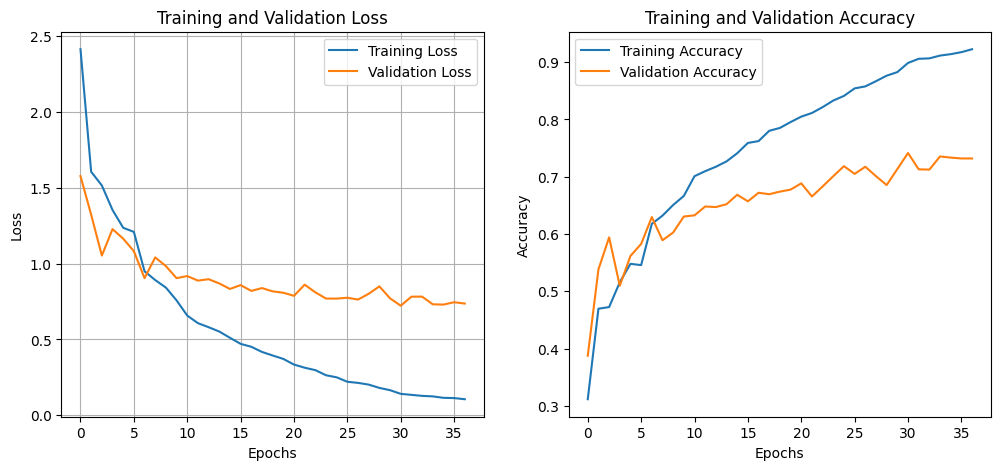

In [8]:
#Model training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 64
epochs = 50

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


history = model.fit(
    x_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        checkpoint_callback,
        lr_scheduler
    ],
    class_weight=class_weights
)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


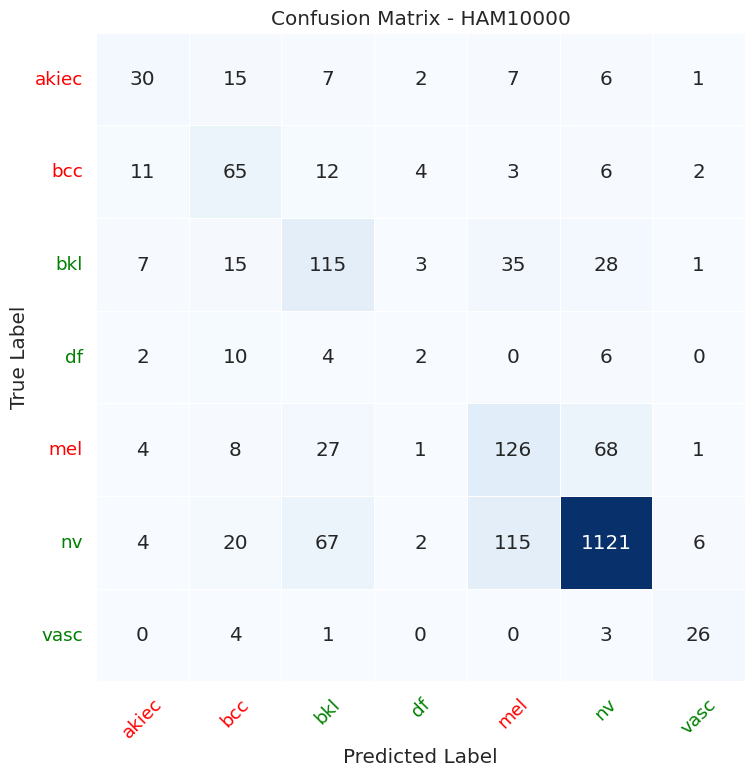

In [15]:
import tensorflow as tf
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prediction
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Classes HAM10000
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
malignant = {'akiec', 'bcc', 'mel'}

# Colors: red for malignant and green for benign
xtick_colors = ['red' if name in malignant else 'green' for name in class_names]
ytick_colors = ['red' if name in malignant else 'green' for name in class_names]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0.5, ax=ax)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix - HAM10000')

for ticklabel, color in zip(ax.get_xticklabels(), xtick_colors):
    ticklabel.set_color(color)
    ticklabel.set_rotation(45)

for ticklabel, color in zip(ax.get_yticklabels(), ytick_colors):
    ticklabel.set_color(color)
    ticklabel.set_rotation(0)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
✅ Prediction: Basal Cell Carcinoma (86.51% of confidence)


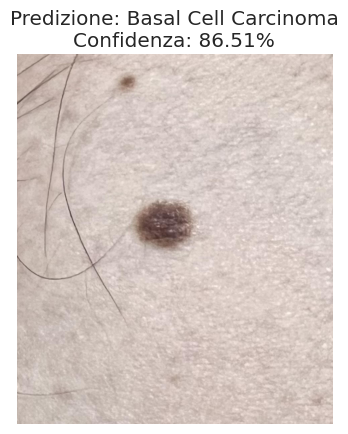

In [19]:
#--------------------TEST ON A REAL PICTURE---------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf


img_size = (72, 72)

class_names = ["Actinic keratoses", "Basal Cell Carcinoma", "Benign keratosis-like lesions", "Dermatofibroma",
               "Melanoma", "Melanocytic Nevi", "Vascular lesions"]

def pre_process_image(image_path, target_size=img_size):

    img = image.load_img(image_path, target_size=target_size)

    img_array = image.img_to_array(img)

    img_array = img_array / 255.0

    img_array = np.expand_dims(img_array, axis=0)

    return img_array

def predict_image_multiclass(image_path, threshold=0.6):

    img_array = pre_process_image(image_path)
    predictions = model.predict(img_array)[0]

    predicted_class_idx = np.argmax(predictions)
    confidence = predictions[predicted_class_idx]

    predicted_class = class_names[predicted_class_idx]

    if confidence < threshold:
        print(f"⚠️ Bad prediction: {predicted_class} ({confidence:.2%} of confidence). You may need a deep analysis.")
    else:
        print(f"✅ Prediction: {predicted_class} ({confidence:.2%} of confidence)")

    img = image.load_img(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predizione: {predicted_class}\nConfidenza: {confidence:.2%}")
    plt.show()

image_path = "/content/Neo_mio.jpg"
predict_image_multiclass(image_path, threshold=0.7)